In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates

# --- Parametre ---
year = 2022
file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/biostat-total-omr.csv"

# --- Les inn og aggreger på nytt som før ---
df = pd.read_csv(file_path, sep=";", decimal=".", na_values=["(null)"])
df = df[df["ARTSID"] == "LAKS"].copy()

grp = (
    df.groupby(["PO_KODE","ÅR","MÅNED_KODE"], as_index=False)
      .agg(
        BEHFISK_STK = ("BEHFISK_STK","sum"),
        DØDFISK_STK = ("DØDFISK_STK","sum"),
      )
)

grp = grp.query("BEHFISK_STK > 0")
grp["pct_dead"] = 100*grp["DØDFISK_STK"]/grp["BEHFISK_STK"]

# --- Regn ut mean, std, min, max over alle år ---
monthly = (
    grp
      .groupby(["PO_KODE","MÅNED_KODE"], as_index=False)
      .agg(
        mean_pct=("pct_dead","mean"),
        std_pct =("pct_dead","std"),
        min_pct =("pct_dead","min"),
        max_pct =("pct_dead","max"),
      )
)

grp 

import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/biostat-total-omr.csv"

# 1) Les inn CSV med semikolon
df = pd.read_csv(file_path, sep=";", decimal=".", na_values=["(null)"])

# 2) Filtrer til LAKS
df_laks = df[df["ARTSID"] == "LAKS"].copy()

# 3) Gruppér på (PO_KODE, ÅR, MÅNED_KODE) og summer BEHFISK_STK og DØDFISK_STK
group_annual = (
    df_laks
    .groupby(["PO_KODE", "ÅR", "MÅNED_KODE"], dropna=False, as_index=False)
    .agg({"BEHFISK_STK": "sum", "DØDFISK_STK": "sum"})
)

# 4) Beregn prosent dødfisk for hver (PO, ÅR, MÅNED)
# Fjern rader med 0 i beholdning før beregning av prosent
group_annual = group_annual[group_annual["BEHFISK_STK"] > 0].copy()

# Beregn prosent dødfisk
group_annual["pct_dead"] = (group_annual["DØDFISK_STK"] / group_annual["BEHFISK_STK"]) * 100

group_annual["pct_dead"] = (group_annual["DØDFISK_STK"] / group_annual["BEHFISK_STK"]) * 100

# 5) Gruppér deretter på (PO_KODE, MÅNED_KODE) for å finne gjennomsnittlig% og std
group_monthly = (
    group_annual
    .groupby(["PO_KODE", "MÅNED_KODE"], dropna=False, as_index=False)["pct_dead"]
    .agg(["mean", "std"])
    .reset_index()
)

#print dataframe
data = group_monthly
data = data.rename(columns={"mean": "mean_pct", "std": "std_pct"})
data  = grp.merge(monthly, on=["PO_KODE","MÅNED_KODE"], how="left")



/var/folders/10/0018jykj75xf64b_qmbd_ptw0000gn/T/ipykernel_77557/699172069.py:108: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.07, right=0.97, top=0.90, hspace=0.6)


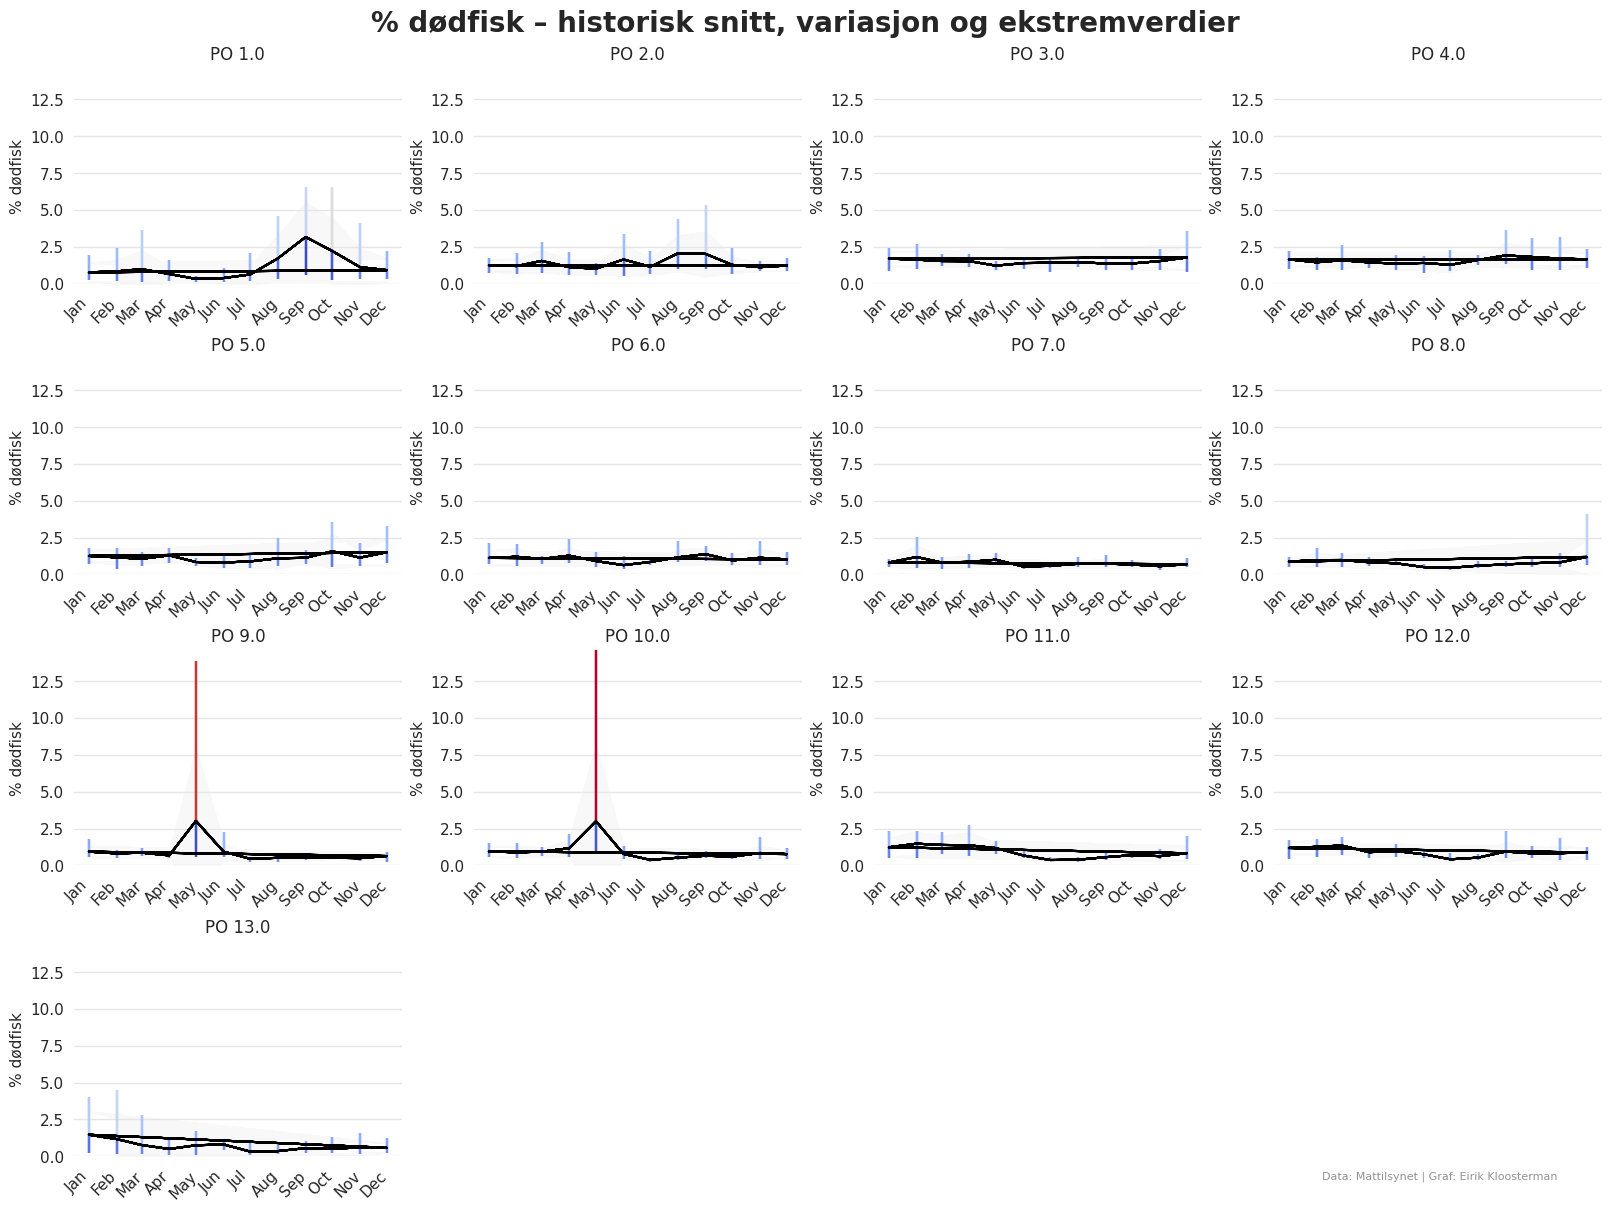

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

# ... anta at du allerede har laget 'data' og 'year' ...

# Lage fiktiv dato midt i hver mnd for x-akse
data["date"] = pd.to_datetime({
    "year":  year,
    "month": data["MÅNED_KODE"],
    "day":   15
})

# Plot-stil
sns.set_style("white")
plt.rcParams["figure.dpi"]      = 100
mpl.rcParams["font.family"]     = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Lato","DejaVu Sans","Arial"]
mpl.rcParams["axes.labelsize"]  = 11
mpl.rcParams["xtick.labelsize"] = 11
mpl.rcParams["ytick.labelsize"] = 11

# Colormap for vlines (valgfritt)
diff_min = data["min_pct"] - data["mean_pct"]
diff_max = data["max_pct"] - data["mean_pct"]
diff_vals = np.concatenate([diff_min, diff_max])
norm = mpl.colors.Normalize(vmin=diff_vals.min(), vmax=diff_vals.max())
cmap = mpl.cm.coolwarm

# Beregn global y-maks for alle subplottene
global_ymax = data["max_pct"].max()

# Subplots
po_codes = data["PO_KODE"].unique()
cols = 4
rows = int(np.ceil(len(po_codes)/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), constrained_layout=True)
axes = axes.flatten()

for ax, po in zip(axes, po_codes):
    df_po = data[data["PO_KODE"] == po]
    
    # Fjerne rammer + grid
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1)
    
    # 1) Grått område = mean ± std
    ax.fill_between(
        df_po["date"],
        df_po["mean_pct"] - df_po["std_pct"],
        df_po["mean_pct"] + df_po["std_pct"],
        color="#f8f8f8",
        zorder=0
    )
    
    # 2) Svart linje for mean
    ax.plot(
        df_po["date"],
        df_po["mean_pct"],
        color="black",
        zorder=10
    )
    
    # 3) Vertikale linjer til ekstremverdier
    for _, r in df_po.iterrows():
        ax.vlines(
            r["date"], r["mean_pct"], r["max_pct"],
            color=cmap(norm(r["max_pct"]-r["mean_pct"])),
            linewidth=1.5,
            zorder=5
        )
        ax.vlines(
            r["date"], r["mean_pct"], r["min_pct"],
            color=cmap(norm(r["min_pct"]-r["mean_pct"])),
            linewidth=1.5,
            zorder=5
        )
    
    # --- Juster x-akseticks til alle måneder og roter vertikalt ---
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # Bare måned, f.eks. "Jan", "Feb"
    ax.tick_params(axis='x', rotation=45, which='major', pad=5)


    # --- Sett samme y-maks for alle subplottene ---
    ax.set_ylim(bottom=0, top=global_ymax)
    
    ax.set_title(f"PO {po}", fontsize=12)
    ax.set_ylabel("% dødfisk")

# Fjern tomme plott om noen
for ax in axes[len(po_codes):]:
    fig.delaxes(ax)

# Hovedtittel og marginjustering
plt.suptitle(
    "% dødfisk – historisk snitt, variasjon og ekstremverdier",
    fontsize=20,
    fontweight="bold",
    x=0.5,
    ha="center"
)
plt.subplots_adjust(left=0.07, right=0.97, top=0.90, hspace=0.6)

# Footer
fig.text(
    0.97, 0.02,
    "Data: Mattilsynet | Graf: Eirik Kloosterman",
    ha="right",
    va="bottom",
    fontsize=8,
    alpha=0.5
)

plt.show()


/var/folders/10/0018jykj75xf64b_qmbd_ptw0000gn/T/ipykernel_77557/1954994113.py:142: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.07, right=0.97, top=0.90, hspace=0.6)


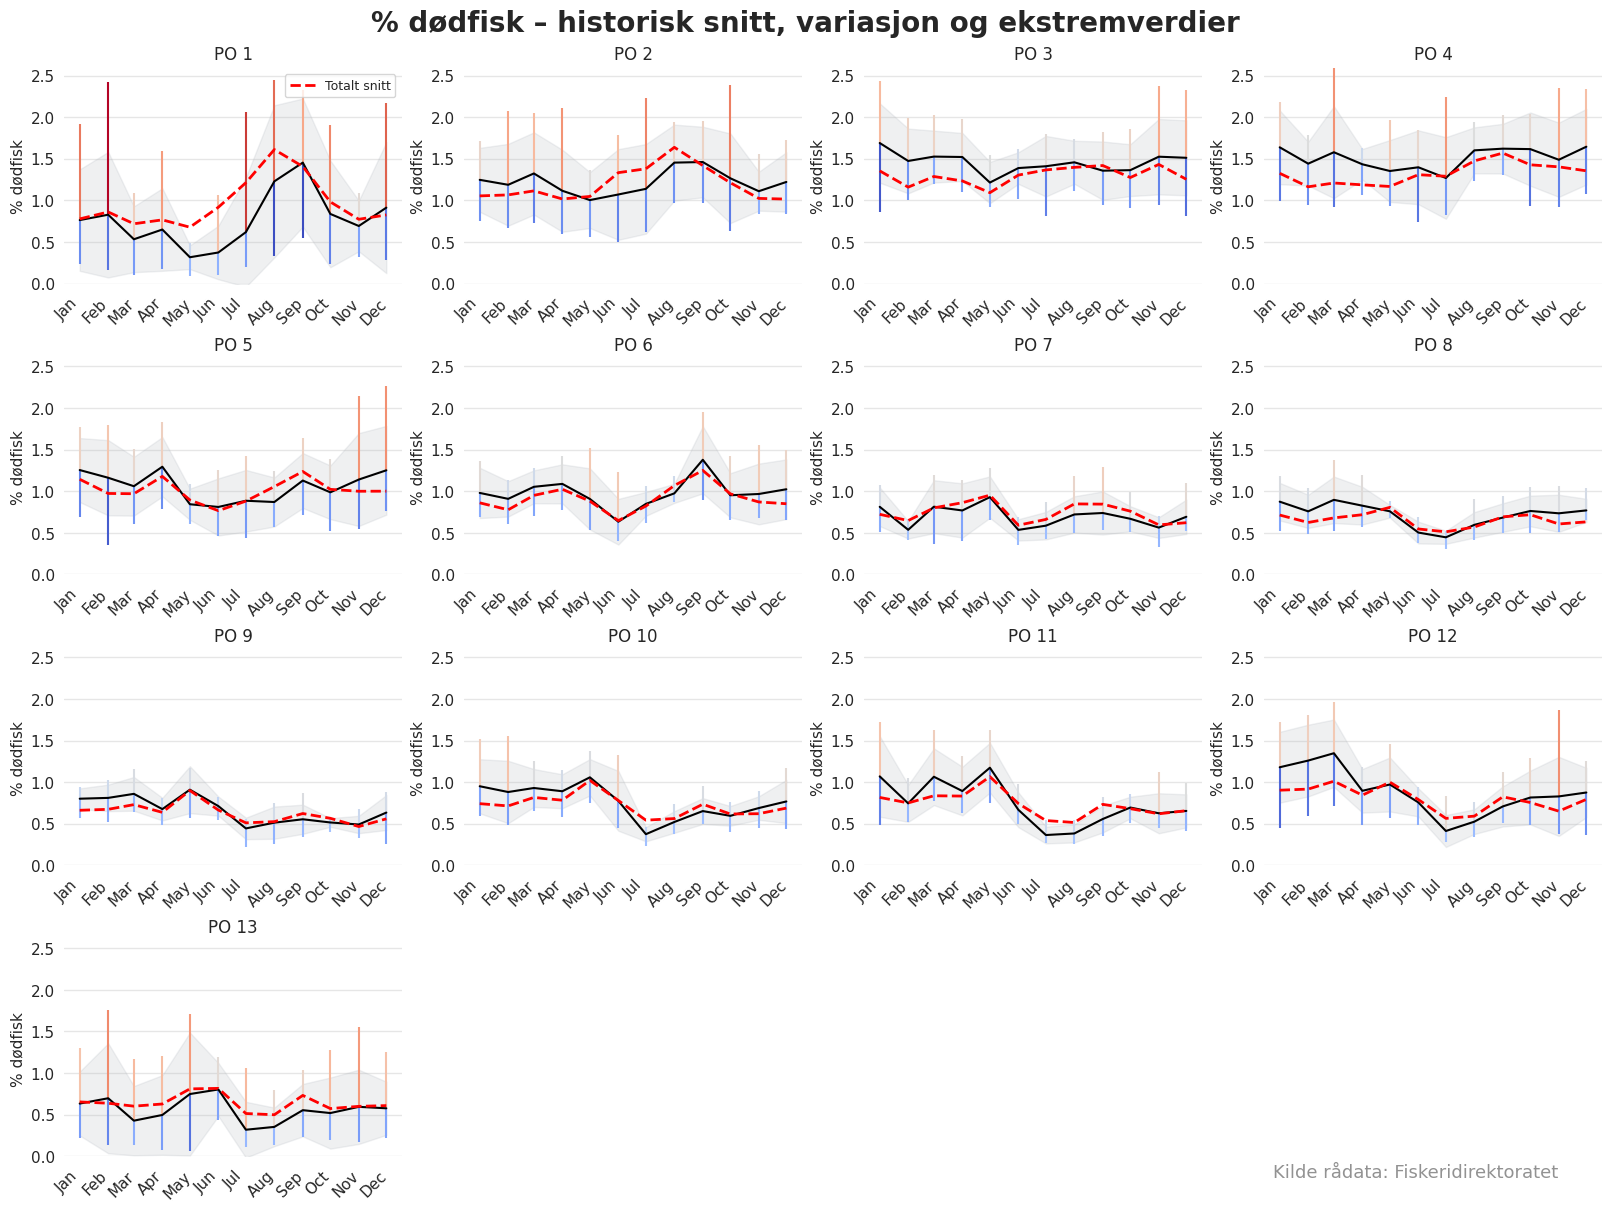

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

# Les inn data
file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics_2017.csv"
data = pd.read_csv(file_path, sep=";")

# Konverter Dato til datetime
data["date"] = pd.to_datetime(data["Dato"])

# Beregn mean, std, min, max for % Dødfisk per PO og måned
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year

agg = (
    data.groupby(["PO", "month"], as_index=False)
        .agg(
            mean_pct=("% Dødfisk", "mean"),
            std_pct=("% Dødfisk", "std"),
            min_pct=("% Dødfisk", "min"),
            max_pct=("% Dødfisk", "max"),
            year=("year", "first")
        )
)

# Lag dato midt i hver måned for x-akse
agg["plot_date"] = pd.to_datetime({
    "year": 2022,  # eller et annet referanseår for x-aksen
    "month": agg["month"],
    "day": 15
})

# Les inn det store datasettet
tot_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics.csv"
data_tot = pd.read_csv(tot_path, sep=";")
data_tot["date"] = pd.to_datetime(data_tot["Dato"])
data_tot["month"] = data_tot["date"].dt.month

# Beregn månedlig snitt for % Dødfisk per PO
agg_tot = (
    data_tot.groupby(["PO", "month"], as_index=False)
        .agg(mean_pct_tot=("% Dødfisk", "mean"))
)
agg_tot["plot_date"] = pd.to_datetime({
    "year": 2022,
    "month": agg_tot["month"],
    "day": 15
})

# Plot-stil
sns.set_style("white")
plt.rcParams["figure.dpi"]      = 100
mpl.rcParams["font.family"]     = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Lato","DejaVu Sans","Arial"]
mpl.rcParams["axes.labelsize"]  = 11
mpl.rcParams["xtick.labelsize"] = 11
mpl.rcParams["ytick.labelsize"] = 11

diff_min = agg["min_pct"] - agg["mean_pct"]
diff_max = agg["max_pct"] - agg["mean_pct"]
diff_vals = np.concatenate([diff_min, diff_max])
norm = mpl.colors.Normalize(vmin=diff_vals.min(), vmax=diff_vals.max())
cmap = mpl.cm.coolwarm

global_ymax = agg["max_pct"].max()
po_codes = agg["PO"].unique()
cols = 4
rows = int(np.ceil(len(po_codes)/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), constrained_layout=True)
axes = axes.flatten()

for ax, po in zip(axes, po_codes):
    df_po = agg[agg["PO"] == po]
    df_tot = agg_tot[agg_tot["PO"] == po]
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1)
    # Grått område = mean ± std
    ax.fill_between(
        df_po["plot_date"],
        df_po["mean_pct"] - df_po["std_pct"],
        df_po["mean_pct"] + df_po["std_pct"],
        color="#b0b6bd",
        alpha=0.2,
        zorder=5
    )
    # Svart linje for mean
    ax.plot(
        df_po["plot_date"],
        df_po["mean_pct"],
        color="black",
        zorder=10
    )
    # Rød linje for tot-middel
    ax.plot(
        df_tot["plot_date"],
        df_tot["mean_pct_tot"],
        color="red",
        linewidth=2,
        linestyle="--",
        label="Totalt snitt" if po == po_codes[0] else None,
        zorder=11
    )
    # Vertikale linjer til ekstremverdier
    for _, r in df_po.iterrows():
        ax.vlines(
            r["plot_date"], r["mean_pct"], r["max_pct"],
            color=cmap(norm(r["max_pct"]-r["mean_pct"])),
            linewidth=1.5,
            zorder=5
        )
        ax.vlines(
            r["plot_date"], r["mean_pct"], r["min_pct"],
            color=cmap(norm(r["min_pct"]-r["mean_pct"])),
            linewidth=1.5,
            zorder=5
        )
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.tick_params(axis='x', rotation=45, which='major', pad=5)
    ax.set_ylim(bottom=0, top=global_ymax)
    ax.set_title(f"PO {int(po)}", fontsize=12)
    ax.set_ylabel("% dødfisk")
    if po == po_codes[0]:
        ax.legend(loc="upper right", fontsize=9)

for ax in axes[len(po_codes):]:
    fig.delaxes(ax)

plt.suptitle(
    "% dødfisk – historisk snitt, variasjon og ekstremverdier",
    fontsize=20,
    fontweight="bold",
    x=0.5,
    ha="center"
)
plt.subplots_adjust(left=0.07, right=0.97, top=0.90, hspace=0.6)
fig.text(
    0.97, 0.02,
    "Kilde rådata: Fiskeridirektoratet",
    ha="right",
    va="bottom",
    fontsize=13,
    alpha=0.5
)
plt.show()